In [1]:
# colab setup

if False:
    from google.colab import drive
    drive.mount('/content/drive/')
    path = "/content/drive/MyDrive/The-Evolution-of-Defection/"

    import sys
    sys.path.append(path)

    %pip install --ignore-installed PyYAML
    %pip install axelrod

In [2]:
import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from copy import deepcopy
from pprint import pprint

np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

import network
from axl_utils import NNplayer, State, set_match, set_play, Tournament

In [4]:
GAME_LEN = 20 + 1
C = axl.Action.C
D = axl.Action.D
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

# exponentially decaying epsilon greedy
# greedy in each iteration will be 0.35 * 0.98 ^[i] + 0.05
greedy = (0.35, 0.98, 0.05)

# Attempt 1
training from scratch

In [5]:
# initializing
dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 400),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(400, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            network.ReplayMemory(4000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN), name='DQN1')

dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 400),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(400, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            network.ReplayMemory(4000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn, State(GAME_LEN), name='DQN2')
del dqn
gc.collect()

param1 = {"lr": 3e-4, 'batch': 128, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
      'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}
param2 = deepcopy(param1)

In [6]:
tournament = Tournament((p1, p2), game=GAME, turns=GAME_LEN)
results = tournament.play()
summary = results.summarise()
headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers).sort_values("Name")

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 129.54it/s]


,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
1,1,DQN1,2.40,0.65,0.0,1.0,0.35,0.30,0.25,0.1,0.857143,0.833333,0.000000,0.5
0,0,DQN2,2.65,0.60,1.0,0.0,0.35,0.25,0.30,0.1,0.428571,0.750000,0.666667,1.0


In [7]:
# initialize experience
[Match((p1, p2)).play() for _ in range(200)]

ls = []
for i in range(30):

    if i % 2 == 0:
      # test in tournament
        with p1:
            with p2:
                p1.network.verbosity = p2.network.verbosity = False
                tournament = Tournament((p1, p2), game=GAME, turns=GAME_LEN)
                results = tournament.play()
                summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
                ls.append(summary)

        print(summary.loc[['DQN1','DQN2'], ['Median_score', 'Cooperation_rating']])

        # save
        with open('data/s3/tn_results.pkl', "wb") as file:
            dill.dump(ls, file)
        with open(f'data/s3/p1_{i}.pkl', "wb") as file:
            dill.dump(p1, file)
        with open(f'data/s3/p2_{i}.pkl', "wb") as file:
            dill.dump(p2, file)

    print(f'--------Iter {i}--------')
    start = time()

    # get experience
    [Match((p1, p2)).play() for _ in range(200)]
    
    # train
    for _ in range(8):
        p1.train(100, param1)
        p2.train(100, param2)
        param1['lr'] = param2['lr'] = param1['lr'] * 0.9
    param1['lr'] = param2['lr'] = 3e-4
    print(p1.network.loss)
    print(p2.network.loss)
    
    if i >= 10:
        g = (greedy[0] * greedy[1] ** i) + greedy[2]
        p1.set_greedy(g)
        p2.set_greedy(g)
    print(f"+ {time() - start:.2f} sec")

--------Iter 1--------
[0.292 0.202]
[0.205 0.504]
+ 668.10 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 162.34it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1           0.7                 0.3
DQN2           2.2                 0.0
--------Iter 2--------
[0.228 0.627]
[0.293 0.429]
+ 715.01 sec
--------Iter 3--------
[0.281 0.383]
[0.24 0.33]
+ 602.17 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.21it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1           1.8                 0.3
DQN2           1.8                 0.3
--------Iter 4--------
[0.287 0.315]
[0.282 0.305]
+ 722.85 sec
--------Iter 5--------
[0.403 0.47 ]
[0.238 0.362]
+ 702.93 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 58.00it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          2.35                0.25
DQN2          1.60                0.40
--------Iter 6--------
[0.186 0.273]
[0.237 0.396]
+ 1011.50 sec
--------Iter 7--------
[0.469 0.317]
[0.269 0.304]
+ 1049.20 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.67it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.35                0.20
DQN2          1.60                0.15
--------Iter 8--------


KeyboardInterrupt: 

### Results 1

In [ ]:
p1.network.greedy = p2.network.greedy = 0.0
play(p1, p2)

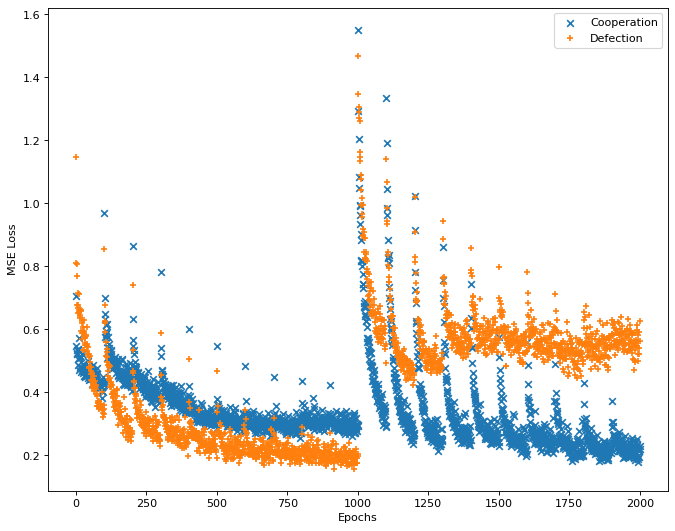

In [8]:
p1.plot(min_ran=0, max_ran=2000)

# Attempt 2
importing the trained model from stage 2

In [34]:
with open("data/s2/p1_94.pkl", "rb") as file:
    p1 = dill.load(file)
    
with open("data/s2/p1_98.pkl", "rb") as file:
    p2 = dill.load(file)
    

p1.network.replay = network.ReplayMemory(4000)
p2.network.replay = network.ReplayMemory(4000)
p1.network.loss_ls = []
p2.network.loss_ls = []
p1.name = 'DQN1'
p2.name = 'DQN2'

param1 = {"lr": 1e-4, 'batch': 128, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
      'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-3), "loss_fn":"mse"}
param2 = deepcopy(param1)

In [35]:
with p1:
    with p2:
        tournament = Tournament((p1, p2), game=GAME, turns=GAME_LEN)
        results = tournament.play()
        summary = results.summarise()
        headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers).sort_values("Name")

Playing matches:  67%|████████████████████████████████████████████▋                      | 2/3 [00:00<00:00, 15.68it/s]

[[26.404 22.293]]
[[26.404 22.293]]
[[25.248 24.752]]
[[25.248 24.752]]
[[24.609 24.588]]
[[24.609 24.588]]
[[23.719 24.334]]
[[23.719 24.334]]
[[14.593 12.985]]
[[14.593 12.985]]
[[19.266 19.35 ]]
[[19.266 19.35 ]]
[[12.878 10.656]]
[[12.878 10.656]]
[[14.211 13.57 ]]
[[14.211 13.57 ]]
[[11.14  10.916]]
[[11.14  10.916]]
[[6.63  5.556]]
[[6.63  5.556]]
[[ 0.388 -0.695]]
[[ 0.388 -0.695]]
[[-0.341 -0.327]]
[[-0.341 -0.327]]
[[-0.419 -0.358]]
[[-0.419 -0.358]]
[[0.548 0.994]]
[[0.548 0.994]]
[[-0.233 -0.02 ]]
[[-0.233 -0.02 ]]
[[-0.247  0.416]]
[[-0.247  0.416]]
[[ 0.041 -0.063]]
[[ 0.041 -0.063]]
[[-0.022 -0.51 ]]
[[-0.022 -0.51 ]]
[[ 0.118 -0.135]]
[[ 0.118 -0.135]]
[[0.33  0.078]]
[[0.33  0.078]]
[[0.11  0.711]]
[[0.11  0.711]]
[[26.404 22.293]]
[[25.576 25.064]]
[[26.022 22.961]]
[[26.654 26.351]]
[[25.248 24.752]]
[[24.792 22.714]]
[[25.117 22.87 ]]
[[26.545 25.628]]
[[24.609 24.588]]
[[25.161 24.243]]
[[24.874 24.703]]
[[24.763 24.163]]
[[23.719 24.334]]
[[23.102 22.988]]
[[24.253

Playing matches: 100%|███████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 14.46it/s]


[[-0.995 -0.375]]
[[-0.215  0.362]]
[[-0.215  0.362]]
[[-0.236 -0.178]]
[[-0.236 -0.178]]
[[0.108 0.012]]
[[0.108 0.012]]
[[ 0.002 -0.479]]
[[ 0.002 -0.479]]
[[ 0.077 -0.21 ]]
[[ 0.077 -0.21 ]]
[[0.003 0.021]]
[[0.003 0.021]]
[[-0.635 -0.647]]
[[-0.635 -0.647]]


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 106.84it/s]


,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
1,1,DQN1,2.00,0.85,0.0,1.0,0.55,0.30,0.05,0.1,0.909091,0.833333,0.000000,1.0
0,0,DQN2,3.25,0.60,1.0,1.0,0.55,0.05,0.30,0.1,0.545455,0.000000,0.833333,0.0


In [36]:
# the first few layers should've became good embeddings by now
# so I'm going to freeze them to speed up the following code

def foo(*args, **kwargs):
    return np.nan

# manually freezing...
# I do regret not implmented a freeze function for layers
p1.network.policy_net.layers[0].backward = foo
p1.network.policy_net.layers[1].backward = foo
p1.network.policy_net.layers[2].backward = foo
p1.network.policy_net.layers[3].backward = foo

p2.network.policy_net.layers[0].backward = foo
p2.network.policy_net.layers[1].backward = foo
p2.network.policy_net.layers[2].backward = foo
p2.network.policy_net.layers[3].backward = foo

# sanity check
p2.network.policy_net.layers[1].backward(1,2,3,4,5,6)

In [ ]:
[Match((p1, p2)).play() for _ in range(200)]

ls = []
greedy = (0.2, 0.97, 0.05)

for i in range(30):

    if i % 2 == 0:
      # test in tournament
        with p1:
            with p2:
                p1.network.verbosity = p2.network.verbosity = False
                tournament = Tournament((p1, p2), game=GAME, turns=GAME_LEN)
                results = tournament.play()
                summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
                ls.append(summary)

        print(summary.loc[['DQN1','DQN2'], ['Median_score', 'Cooperation_rating']])

        # save
        with open('data/s3/tn_results_2.pkl', "wb") as file:
            dill.dump(ls, file)
        with open(f'data/s3/p1_2_{i}.pkl', "wb") as file:
            dill.dump(p1, file)
        with open(f'data/s3/p2_2_{i}.pkl', "wb") as file:
            dill.dump(p2, file)

    print(f'--------Iter {i}--------')
    start = time()

    # get experience
    [Match((p1, p2)).play() for _ in range(200)]
    
    # train
    for _ in range(8):
        p1.train(80, param1)
        p2.train(80, param2)
        param1['lr'] = param2['lr'] = param1['lr'] * 0.9
    param1['lr'] = param2['lr'] = 1e-4
    print(p1.network.loss)
    print(p2.network.loss)
    
    g = (greedy[0] * greedy[1] ** i) + greedy[2]
    p1.set_greedy(g)
    p2.set_greedy(g)
    print(f"+ {time() - start:.2f} sec")

Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.30it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.30                0.20
DQN2          1.55                0.15
--------Iter 0--------
[0.635 0.905]
[0.757 1.03 ]
+ 390.92 sec
--------Iter 1--------
[0.63  1.004]
[0.705 0.986]
+ 365.10 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 118.41it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.45                0.25
DQN2          1.70                0.20
--------Iter 2--------
[0.651 1.101]
[0.759 0.884]
+ 361.06 sec
--------Iter 3--------
[0.596 0.9  ]
[0.887 0.938]
+ 359.94 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 116.82it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.35                0.25
DQN2          1.85                0.15
--------Iter 4--------
[0.593 0.879]
[0.696 0.948]
+ 365.71 sec
--------Iter 5--------
[0.693 0.934]
[0.61  0.933]
+ 362.54 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 106.38it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.25                0.15
DQN2          1.50                0.10
--------Iter 6--------
[0.926 0.992]
[0.595 0.83 ]
+ 360.81 sec
--------Iter 7--------
[0.775 0.936]
[0.591 0.83 ]
+ 364.30 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 114.18it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.30                0.35
DQN2          2.05                0.20
--------Iter 8--------
[0.796 0.921]
[0.812 1.064]
+ 362.99 sec
--------Iter 9--------
[0.719 0.823]
[0.79  1.041]
+ 362.22 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 92.96it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1           1.3                0.25
DQN2           1.8                0.15
--------Iter 10--------
[0.716 0.921]
[0.752 0.947]
+ 365.03 sec
--------Iter 11--------
[0.629 1.006]
[0.84 1.04]
+ 365.10 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 99.21it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1           0.9                 0.1
DQN2           1.4                 0.0
--------Iter 12--------
[0.814 1.052]
[0.814 1.103]
+ 363.63 sec
--------Iter 13--------
[0.932 0.911]
[0.61  0.839]
+ 363.17 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 120.19it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.55                0.05
DQN2          1.05                0.15
--------Iter 14--------
[0.671 0.836]
[0.553 0.996]
+ 365.32 sec
--------Iter 15--------
[0.729 0.954]
[0.505 0.694]
+ 364.76 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 178.58it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.20                0.00
DQN2          0.95                0.05
--------Iter 16--------
[0.638 0.754]
[0.565 0.778]
+ 368.58 sec
--------Iter 17--------
[0.757 0.728]
[0.759 1.007]
+ 362.87 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 109.23it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.10                0.10
DQN2          1.35                0.05
--------Iter 18--------
[0.73  0.774]
[0.821 1.132]
+ 363.17 sec
--------Iter 19--------
[0.709 0.87 ]
[0.778 1.183]
+ 363.69 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 112.11it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.20                0.00
DQN2          0.95                0.05
--------Iter 20--------
[0.754 0.859]
[0.716 1.246]
+ 364.31 sec
--------Iter 21--------
[0.695 0.827]
[0.532 0.783]
+ 364.59 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 107.76it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          0.95                0.05
DQN2          1.20                0.00
--------Iter 22--------
[0.623 0.747]
[0.446 0.776]
+ 364.57 sec
--------Iter 23--------
[0.56  0.625]
[0.477 0.709]
+ 361.12 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 82.24it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1           0.9                 0.1
DQN2           1.4                 0.0
--------Iter 24--------
[0.527 0.609]
[0.481 0.638]
+ 367.57 sec
--------Iter 25--------
[0.704 0.594]
[0.549 0.63 ]
+ 365.77 sec


Analysing: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 99.41it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.10                0.10
DQN2          1.35                0.05
--------Iter 26--------
[0.866 0.795]
[0.62  0.651]
+ 363.31 sec
--------Iter 27--------
[0.646 0.782]
[0.539 0.744]
+ 367.50 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 106.84it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1          1.20                0.15
DQN2          1.45                0.10
--------Iter 28--------
[0.883 0.763]
[0.577 0.727]
+ 367.41 sec
--------Iter 29--------
[0.903 0.643]
[0.517 0.653]
+ 364.72 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 111.61it/s]


      Median_score  Cooperation_rating
Name                                  
DQN1           0.9                 0.1
DQN2           1.4                 0.0
--------Iter 30--------
[0.458 0.505]
[0.506 0.658]
+ 365.80 sec
--------Iter 31--------


### results 2

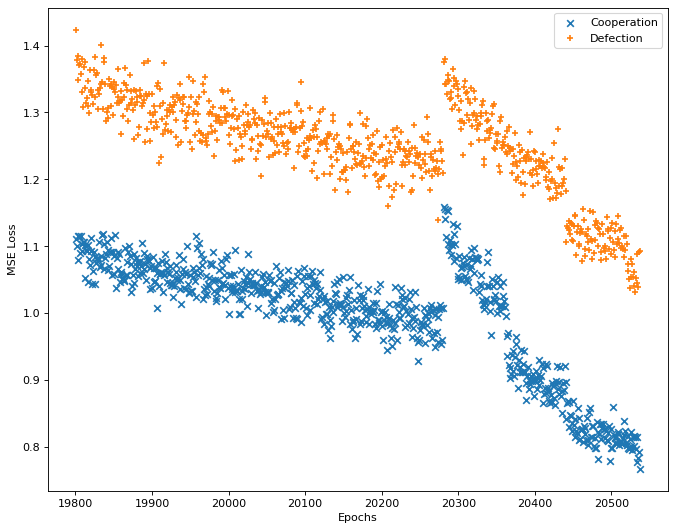

In [44]:
p1.plot(min_ran=19800, max_ran=-1)

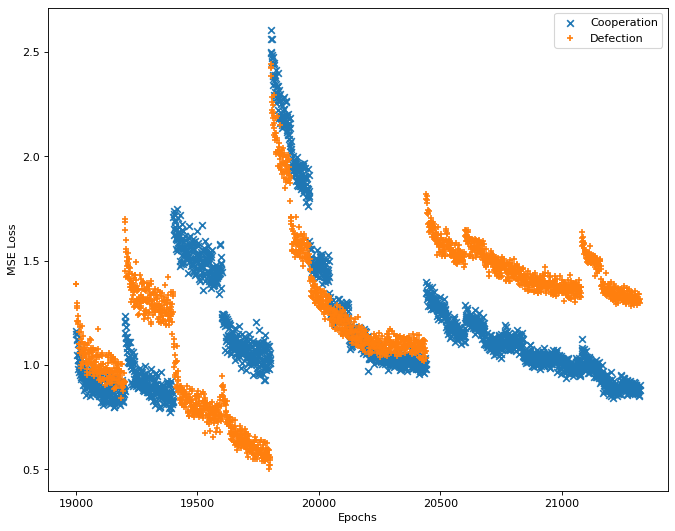

In [43]:
p2.plot(min_ran=19800, max_ran=-1)